In [2]:
map = "XXXXXXXXXXXX\nX...X..X..eX\nX.X....X.XXX\nX..X.X.X.X.X\nXX.XXX.X...X\nX........X.X\nXsXX...X...X\nXXXXXXXXXXXX"

print(map)

XXXXXXXXXXXX
X...X..X..eX
X.X....X.XXX
X..X.X.X.X.X
XX.XXX.X...X
X........X.X
XsXX...X...X
XXXXXXXXXXXX


In [3]:
map_split = map.split("\n")
print(map_split)

['XXXXXXXXXXXX', 'X...X..X..eX', 'X.X....X.XXX', 'X..X.X.X.X.X', 'XX.XXX.X...X', 'X........X.X', 'XsXX...X...X', 'XXXXXXXXXXXX']


In [4]:
# Create an empty graph
import networkx as nx

maze_graph = nx.Graph()

In [5]:
# Add the nodes (cells) to the graph
for y in range(len(map_split)): # go from bottom up
    for x in range(len(map_split[0])):
        if map_split[y][x] != 'X': #1 is used to represent walls
            
            # reverse y axis order before adding node
            y_reverse = len(map_split) - 1 - y

            maze_graph.add_node((x, y_reverse))
            
            # get starting node
            if map_split[y][x] == 's':
                start_node = (x, y_reverse)

            # get ending node
            if map_split[y][x] == 'e':
                end_node = (x, y_reverse)

# Add the edges (connections) to the graph
for node in maze_graph.nodes:
    x, y = node

    # Check the top cell (y + 1)
    if (x, y + 1) in maze_graph.nodes:
        maze_graph.add_edge(node, (x, y + 1))

    # Check the bottom cell (y - 1)
    if (x, y - 1) in maze_graph.nodes:
        maze_graph.add_edge(node, (x, y - 1))

    # Check the left cell (x - 1)
    if (x - 1, y) in maze_graph.nodes:
        maze_graph.add_edge(node, (x - 1, y))

    # Check the right cell (x + 1)
    if (x + 1, y) in maze_graph.nodes:
        maze_graph.add_edge(node, (x + 1, y))

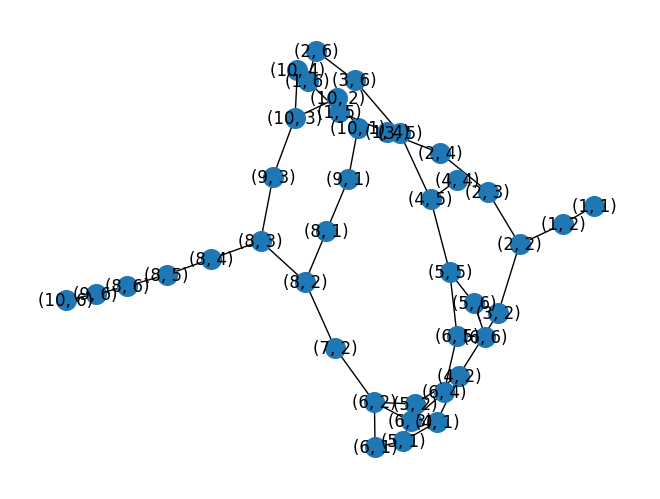

In [39]:
nx.draw(maze_graph, pos=nx.spring_layout(maze_graph), with_labels=True, node_size=200)

# Solving TSP using christofides algorithm

In [6]:
# dict class so that any combination of 2 nodes in any order can access the path (if the combination of nodes exist)
class DoubleKeyDict(dict):
    def __init__(self):
        super().__init__()

    def __getitem__(self, key):
        node1, node2 = key

        if (node1, node2) in self.keys():
            return super().__getitem__((node1, node2))

        elif (node2, node1) in self.keys():
            return super().__getitem__((node2, node1))

        else:
            return KeyError(key)

In [16]:
# nodes = [(6,2), (1,5), (6,4), (10,4)] # nodes 

In [18]:
# nx.draw(graph, pos=nx.spring_layout(graph), with_labels=True, node_size=200)

In [17]:
# mst = nx.minimum_spanning_tree(graph)
# nx.draw(mst, pos=nx.spring_layout(mst), with_labels=True, node_size=200)

In [185]:
# step 1 is to convert the graph with start and end nodes into a weighted graph
def convert_to_weighted_graph(map_graph, all_nodes=list):
    # all_nodes.append(start_node) # append start node to back
    paths_dict = DoubleKeyDict()

    # adds every combination of nodes into the dict, with the coordinate paths (shortest path using dijkstra)
    for i in range(len(all_nodes)-1):
        for j in range(i+1, len(all_nodes)):

            path = nx.shortest_path(map_graph, all_nodes[i], all_nodes[j])
            # put in dict
            paths_dict[(all_nodes[i], all_nodes[j])] = path

    # compute weighted graph of the nodes
    graph = nx.Graph()
    for node in all_nodes:
        graph.add_node(node)

    for all_nodes, path in paths_dict.items():
        weight = len(path)
        graph.add_edge(all_nodes[0], all_nodes[1], weight=weight)

    return graph


# step 2 is to get the minimum spanning tree
def get_mst(graph):
    return nx.minimum_spanning_tree(graph)


# step 3 is to find odd degree edges and find the minimum matching pairs to connect
# naive approximated way of doing it:
# 1. 

import numpy as np
def make_minimum_matching_pairs(mst, weighted_graph):

    # get list of odd nodes
    odd_nodes = [n for n,d in mst.degree if d % 2 == 1]

    # check if list is empty
    if len(odd_nodes) != 0:
        n = len(odd_nodes)
        matrix=np.zeros((n, n))

        print(odd_nodes)
        for i, node1 in enumerate(odd_nodes[:-1]):
            for j, node2 in enumerate(odd_nodes[i+1:], i+1):
                if i == j:
                    matrix[i][j] = 0
                # print(i, j)
                # print(node1,node2)
                else:
                    matrix[i][j] = weighted_graph.get_edge_data(node1, node2)['weight']
                    matrix[j][i] = weighted_graph.get_edge_data(node1, node2)['weight']
                # matrix[i].append(weighted_graph.get_edge_data(node1, node2)['weight'])

    # check matrix
    print(matrix)

    ### FIND MIN MATCHING PAIRS

    # 1. search through whole array to find global min
    removed_index = []

    min = matrix[1][0]
    first_node_index = 1
    second_node_index = 0

    for _ in range((n/2) - 1):
        for i in range(2, len(matrix)): # start from 2nd index, as first index is taken is minimum (for now)

            if i in removed_index:
                continue

            for j in range(i): # i is the number of elements in matrix(staircase like loop)
                if j in removed_index:
                    continue

                if matrix[i][j] < min:
                    min = matrix[i][j]
                    first_node_index = i
                    second_node_index = j

        # add edge to mst
        mst.add_edge(odd_nodes[i], odd_nodes[j], weight=min)                    

    # adding 1st and 2nd node index to removed index
    removed_index.append(first_node_index)
    removed_index.append(second_node_index)

    return mst

In [186]:
weighted_graph = convert_to_weighted_graph(maze_graph, [(3,2), (6,5), (1,5), (6,4), (10,4), (6,1)])
# print(weighted_graph.edges(data="weight"))
mst = get_mst(weighted_graph)

new_mst = make_minimum_matching_pairs(mst, weighted_graph)

[(6, 5), (1, 5), (10, 4), (6, 1)]
[[ 0.  8. 10.  5.]
 [ 8.  0. 15. 10.]
 [10. 15.  0.  8.]
 [ 5. 10.  8.  0.]]


In [188]:
new_mst.degree

DegreeView({(3, 2): 2, (6, 5): 1, (1, 5): 1, (6, 4): 2, (10, 4): 1, (6, 1): 3})

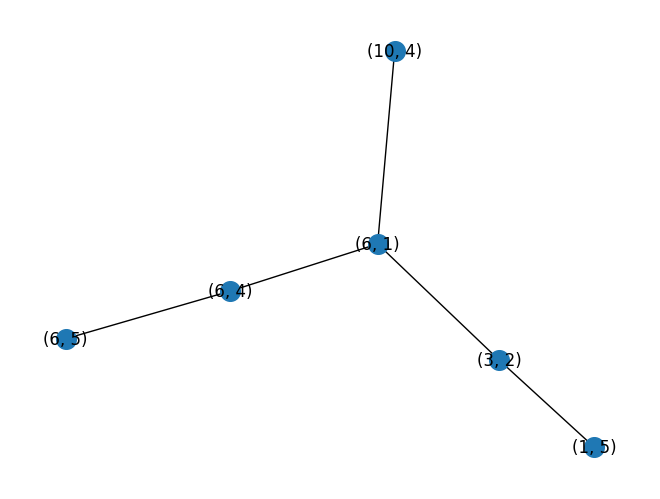

In [187]:
nx.draw(new_mst, pos=nx.spring_layout(mst), with_labels=True, node_size=200)

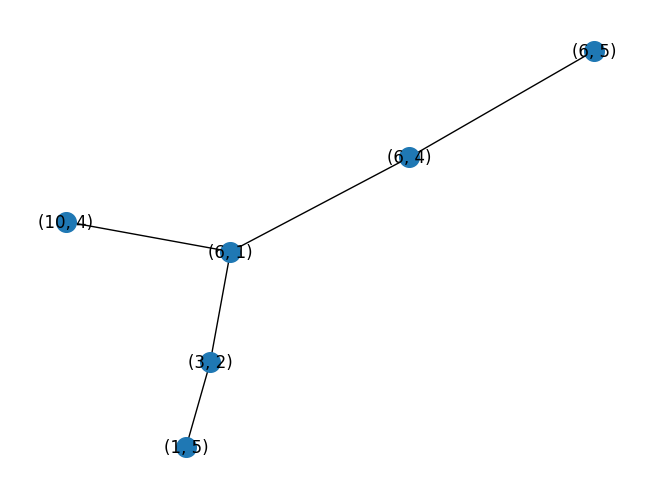

In [177]:
nx.draw(mst, pos=nx.spring_layout(mst), with_labels=True, node_size=200)

In [80]:
list(mst.degree)

[((6, 5), 1), ((1, 5), 1), ((6, 4), 3), ((10, 4), 1), ((3, 2), 2)]

In [55]:
weighted_graph.get_edge_data((10,4),(6,4))['weight']

9

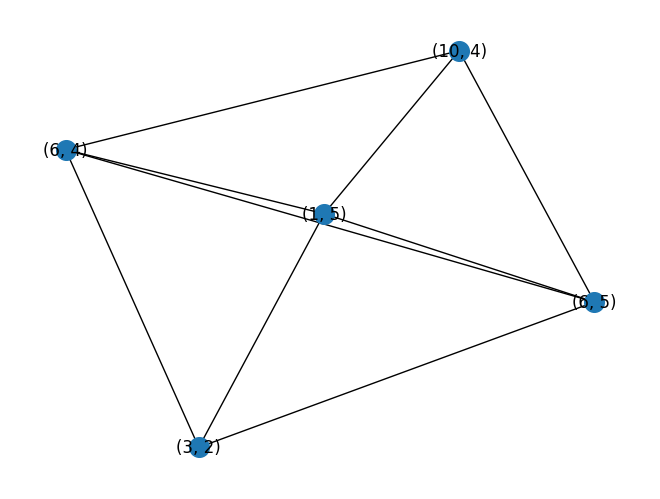

In [50]:
nx.draw(weighted_graph, pos=nx.spring_layout(weighted_graph), with_labels=True, node_size=200)

In [7]:
tsp = nx.approximation.traveling_salesman_problem
tsp(maze_graph, nodes=[(3,2), (6,5), (1,5), (6,4), (10,4), (6,1)])

[(3, 2),
 (2, 2),
 (2, 3),
 (2, 4),
 (1, 4),
 (1, 5),
 (1, 6),
 (2, 6),
 (3, 6),
 (3, 5),
 (4, 5),
 (5, 5),
 (6, 5),
 (6, 4),
 (6, 3),
 (6, 2),
 (6, 1),
 (6, 2),
 (7, 2),
 (8, 2),
 (8, 3),
 (9, 3),
 (10, 3),
 (10, 4),
 (10, 3),
 (9, 3),
 (8, 3),
 (8, 2),
 (7, 2),
 (6, 2),
 (5, 2),
 (4, 2),
 (3, 2)]